# Netflix Movie Recommender — Project Primer

- This project builds and evaluates collaborative-filtering models for movie-rating prediction using a curated sample of the Netflix Prize dataset.
- The repo includes two pre-generated splits (~10k users across ~3k movies) with fixed **train** and **validation** sets for reproducible experiments.
- Because the **Surprise** library doesn’t natively consume fixed splits, the code demonstrates a simple pattern for loading and training on predefined folds.
- Background on the Netflix Prize and its impact:
  - https://towardsdatascience.com/deep-dive-into-netflixs-recommender-system-341806ae3b48
  - https://www.thrillist.com/entertainment/nation/the-netflix-prize
  - https://analyticsindiamag.com/how-useful-was-the-netflix-prize-really/

In [10]:
import numpy as np
import pyarrow.feather as feather
import pandas as pd

In [11]:
import pyarrow.feather as feather
import pandas as pd
from surprise import Dataset, Reader, BaselineOnly, accuracy, SVD, SVDpp, KNNBasic, CoClustering, NMF
from surprise.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from joblib import parallel_backend
import os, psutil



In [12]:
df_train = feather.read_feather('netflix-5k.train.feather')
df_val = feather.read_feather('netflix-5k.validation.feather')
df_titles = feather.read_feather('netflix-5k.movie_titles.feather')

In [13]:
display(df_titles)

,movieID,imdb_id,imdb_date,date,title,genre
0,3,1860,1997,1997,Character,Drama
1,8,27899,2004,2004,What the #$*! Do We Know!?,Comedy|Documentary|Drama
2,16,76,1995,1996,Screamers,Action|Sci-Fi|Thriller
3,18,249,1994,1994,Immortal Beloved,Drama|Romance
4,26,7368,2004,2004,Never Die Alone,Crime|Drama|Thriller
...,...,...,...,...,...,...
4329,17761,6285,2003,2003,Levity,Drama
4330,17762,1653,1997,1997,Gattaca,Drama|Sci-Fi|Thriller
4331,17763,3813,1978,1978,Interiors,Drama
4332,17764,2396,1998,1998,Shakespeare in Love,Comedy|Drama|Romance


In [14]:
display(df_train)

,userID,movieID,rating
0,1000596,10036,4.0
1,1000596,10100,2.0
2,1000596,10209,3.0
3,1000596,10212,3.0
4,1000596,10225,3.0
...,...,...,...
1287012,99993,9683,4.0
1287013,99993,9685,4.0
1287014,99993,9800,2.0
1287015,99993,9939,5.0


In [15]:
display(df_val)

,userID,movieID,rating
0,1000596,10827,4.0
1,1000596,11089,4.0
2,1000596,11279,3.0
3,1000596,11337,3.0
4,1000596,1180,3.0
...,...,...,...
321485,99993,8764,5.0
321486,99993,9092,4.0
321487,99993,9508,4.0
321488,99993,9788,3.0


In [16]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_train[['userID','movieID',
                                      'rating']],reader)
datav = Dataset.load_from_df(df_val[['userID','movieID',
                                       'rating']],reader)
trainset = data.build_full_trainset()
NA,valset = train_test_split(datav, test_size=1.0)

print ('Run simple baseline model')
bl = BaselineOnly()
model = bl.fit(trainset)
predictions = bl.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions,verbose=False),3)))

Run simple baseline model
Estimating biases using als...
RMSE = 0.9


In [17]:
display(predictions)

[Prediction(uid=1261953, iid=12473, r_ui=5.0, est=4.491823254546003, details={'was_impossible': False}),
 Prediction(uid=66885, iid=11090, r_ui=4.0, est=3.513120793808581, details={'was_impossible': False}),
 Prediction(uid=1021687, iid=9197, r_ui=3.0, est=2.9863484727766596, details={'was_impossible': False}),
 Prediction(uid=1180716, iid=13728, r_ui=5.0, est=3.8703608714300484, details={'was_impossible': False}),
 Prediction(uid=1639014, iid=15421, r_ui=5.0, est=4.580450521386918, details={'was_impossible': False}),
 Prediction(uid=2497537, iid=6060, r_ui=2.0, est=3.204061205351598, details={'was_impossible': False}),
 Prediction(uid=2381481, iid=15788, r_ui=2.0, est=3.55732818700174, details={'was_impossible': False}),
 Prediction(uid=2286661, iid=16954, r_ui=4.0, est=4.165509924681457, details={'was_impossible': False}),
 Prediction(uid=1234355, iid=6994, r_ui=4.0, est=3.6309135907670385, details={'was_impossible': False}),
 Prediction(uid=1062387, iid=7330, r_ui=5.0, est=4.1608348

In [18]:
# Let's build a pandas dataframe with all the predictions

def get_Iu(uid):
    """Return the number of items rated by given user"""
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item"""
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
df = df.drop(['details'],axis=1)

In [19]:
display(df)

,uid,iid,rui,est,Iu,Ui,err
0,1261953,12473,5.0,4.491823,256,630,0.508177
1,66885,11090,4.0,3.513121,319,485,0.486879
2,1021687,9197,3.0,2.986348,210,48,0.013652
3,1180716,13728,5.0,3.870361,370,2305,1.129639
4,1639014,15421,5.0,4.580451,283,513,0.419549
...,...,...,...,...,...,...,...
321485,252495,14918,3.0,3.357415,313,474,0.357415
321486,1694565,11337,5.0,3.936151,348,1871,1.063849
321487,622909,7509,3.0,2.934040,256,1209,0.065960
321488,2571411,6833,4.0,4.047469,309,990,0.047469


## Now let's look at the API documents for the 'baseline' only model in surprise: https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration

## Or after some digging, even more informative -- https://github.com/NicolasHug/Surprise/blob/master/doc/source/prediction_algorithms.rst

In [20]:
# So let's setup a grid search based on these options. For simplicity, we will look at ALS only.

param_grid = {'bsl_options': 
                  {'method':['als'],'n_epochs':[5, 10, 20, 30, 50], 
                   'reg_i': [8, 9, 10, 11, 12], # lambda 2
                   'reg_u': [3, 4, 5, 6, 7],# lambda 3
                  }
             }

unwrapped_grid = {'method':['als'],'n_epochs':[5, 10, 20, 30, 50], 
                   'reg_i': [8, 9, 10, 11, 12], # lambda 2
                   'reg_u': [3, 4, 5, 6, 7],# lambda 3
                  }

# Seems OK. How many permutations are there exactly?
from sklearn.model_selection import ParameterGrid
pg = ParameterGrid(unwrapped_grid)
print ('Total Permutations = ',len(pg))

Total Permutations =  125


In [21]:
# Now let's run it.
# I am forcing joblib to use multiprocessing to avoid problems with failed threads.

with parallel_backend('multiprocessing', n_jobs=1):
    gs = GridSearchCV(BaselineOnly, param_grid, joblib_verbose=10, cv=5,
                          measures=['rmse'], n_jobs=1)
    gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

rmse_params = gs.best_params['rmse']

bl_tuned = BaselineOnly(rmse_params)
model = bl_tuned.fit(trainset)
predictions = bl_tuned.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions,verbose=False),3)))


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.5s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    4.8s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    7.8s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:   13.4s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   18.4s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:   25.0s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   31.6s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   40.3s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   49.3s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:   59.8s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:  1.2min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:  1.4min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:  1.6min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 112 tasks      | elapsed:  1.8min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:  2.1min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 144 tasks      | elapsed:  2.5min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  2.8min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 180 tasks      | elapsed:  3.2min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  3.6min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 220 tasks      | elapsed:  4.0min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 241 tasks      | elapsed:  4.5min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 264 tasks      | elapsed:  5.1min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:  5.7min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 312 tasks      | elapsed:  6.4min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 337 tasks      | elapsed:  7.2min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:  7.9min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 391 tasks      | elapsed:  8.8min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 420 tasks      | elapsed:  9.8min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed: 11.0min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 480 tasks      | elapsed: 12.2min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 511 tasks      | elapsed: 13.5min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

[Parallel(n_jobs=1)]: Done 544 tasks      | elapsed: 15.2min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

[Parallel(n_jobs=1)]: Done 577 tasks      | elapsed: 16.9min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

[Parallel(n_jobs=1)]: Done 612 tasks      | elapsed: 18.8min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done 625 out of 625 | elapsed: 19.6min finished


0.9020362843356432
{'bsl_options': {'method': 'als', 'n_epochs': 50, 'reg_i': 8, 'reg_u': 3}}
Estimating biases using als...
RMSE = 0.9


[Parallel(n_jobs=1)]: Done 625 out of 625 | elapsed: 173.9min finished


0.9021362807394795
{'bsl_options': {'method': 'als', 'n_epochs': 50, 'reg_i': 8, 'reg_u': 3}}
Estimating biases using als...
RMSE = 0.9


In [22]:
# That was really slow, so let's setup a randomized search based on these options. 
# For simplicity, we will look at ALS only.

param_grid = {'bsl_options': 
                  {'method':['als'],'n_epochs':[5, 10, 20, 30, 50], 
                   'reg_i': [8, 9, 10, 11, 12], # lambda 2
                   'reg_u': [3, 4, 5, 6, 7],# lambda 3
                  }
             }
with parallel_backend('multiprocessing', n_jobs=1):
    gs = RandomizedSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=5, n_iter=8, 
                            n_jobs=1, joblib_verbose=10)
    gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

rmse_params = gs.best_params['rmse']

bl_tuned = BaselineOnly(rmse_params)
model = bl_tuned.fit(trainset)
predictions = model.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions,verbose=False),3)))

Estimating biases using als...


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.1s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    7.9s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:   17.8s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:   30.1s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   39.7s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:   57.6s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:  1.2min


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.4min finished


0.9021479204437736
{'bsl_options': {'method': 'als', 'n_epochs': 50, 'reg_i': 8, 'reg_u': 3}}
Estimating biases using als...
RMSE = 0.9


## Note that while my attempt to tune the BaselineOnly method did not result in any noticeable performance improvements based on RMSE, that is not entirely surprising based on how this algorithm works. My goal was to show you how to tune the parameters using two different methods, so that you could more easily test and tune other algorithms from surprise.

# Algorithm 1 - Singular Value Decomposition

In [23]:
parameters_grid = {"n_factors": [60, 70, 80, 90, 100, 110, 120, 130],
              "n_epochs": [20, 30, 40, 50, 60, 70, 80],
              "biased": [True, False],
               "init_mean": [0, 1, 2, 3, 4, 5, 6],
                "init_std_dev": [0.1, 0.30, 0.50, 0.70, 0.90, 1.10, 1.30]}

with parallel_backend('multiprocessing', n_jobs=-1):
    SVD_parameters = RandomizedSearchCV(SVD, parameters_grid, measures=['rmse', 'mae', 'mse'], cv=5, n_iter = 8, n_jobs = -1,  joblib_verbose=10)
    SVD_parameters.fit(data)

print(SVD_parameters.best_score['rmse'])
print(SVD_parameters.best_params['rmse'])

mse_parameters_SVD = SVD_parameters.best_params['mse']
rmse_parameters_SVD = SVD_parameters.best_params['rmse']
mae_parameters_SVD = SVD_parameters.best_params['mae']

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:   50.7s remaining:   27.3s
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:   56.1s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done  36 out of  40 | elapsed:  1.0min remaining:    6.8s


0.9385964157399661
{'n_factors': 110, 'n_epochs': 50, 'biased': False, 'init_mean': 0, 'init_std_dev': 0.3}


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished


In [24]:
SVD_rmse = SVD(n_factors = rmse_parameters_SVD['n_factors'], n_epochs = rmse_parameters_SVD['n_epochs'], biased = rmse_parameters_SVD['biased'], init_mean = rmse_parameters_SVD['init_mean'], init_std_dev = rmse_parameters_SVD['init_std_dev'])
SVD_rmse.fit(trainset)
SVD_rmse_predictions = SVD_rmse.test(valset)

SVD_mse = SVD(n_factors = mse_parameters_SVD['n_factors'], n_epochs = mse_parameters_SVD['n_epochs'], biased = mse_parameters_SVD['biased'], init_mean = mse_parameters_SVD['init_mean'], init_std_dev = mse_parameters_SVD['init_std_dev'])
SVD_mse.fit(trainset)
SVD_mse_predictions = SVD_mse.test(valset)

SVD_mae = SVD(n_factors = mae_parameters_SVD['n_factors'], n_epochs = mae_parameters_SVD['n_epochs'],biased = mae_parameters_SVD['biased'], init_mean = mae_parameters_SVD['init_mean'], init_std_dev = mae_parameters_SVD['init_std_dev'])
SVD_mae.fit(trainset)
SVD_mae_predictions = SVD_mae.test(valset)

print("mae {SVD} accuracy is:", accuracy.mae(SVD_mae_predictions, verbose = False))
print("mses {SVD} accuracy is:",accuracy.mse(SVD_mse_predictions, verbose = False))
print("rmse {SVD} accuracy is:", accuracy.rmse(SVD_rmse_predictions, verbose = False))

mae {SVD} accuracy is: 0.7044085819112049
mses {SVD} accuracy is: 0.8259673010804006
rmse {SVD} accuracy is: 0.9096440157057164


In [25]:
df = pd.DataFrame(SVD_rmse_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Ui'] = df.iid.apply(get_Ui)
df['Iu'] = df.uid.apply(get_Iu)
df['err'] = abs(df.est - df.rui)

df = df.drop(['details'],axis=1)
display(df)

,uid,iid,rui,est,Ui,Iu,err
0,1261953,12473,5.0,4.235705,630,256,0.764295
1,66885,11090,4.0,3.491753,485,319,0.508247
2,1021687,9197,3.0,1.551043,48,210,1.448957
3,1180716,13728,5.0,4.206048,2305,370,0.793952
4,1639014,15421,5.0,4.577369,513,283,0.422631
...,...,...,...,...,...,...,...
321485,252495,14918,3.0,2.904838,474,313,0.095162
321486,1694565,11337,5.0,4.565448,1871,348,0.434552
321487,622909,7509,3.0,3.366275,1209,256,0.366275
321488,2571411,6833,4.0,3.990039,990,309,0.009961


# Algorithm 2 - KNNBasic

In [26]:
parameters_grid = {"k": [40, 50, 60, 70, 80],
              "min_k": [1, 2, 4, 8, 16]}

with parallel_backend('multiprocessing', n_jobs=-1):
    KNN_parameters = RandomizedSearchCV(KNNBasic, parameters_grid, measures=['rmse', 'mae', 'mse'], cv=5, n_iter = 8, n_jobs = -1,  joblib_verbose=10)
    KNN_parameters.fit(data)

print(KNN_parameters.best_score['rmse'])
print(KNN_parameters.best_params['rmse'])

mse_parameters_KNN = KNN_parameters.best_params['mse']
rmse_parameters_KNN = KNN_parameters.best_params['rmse']
mae_parameters_KNN = KNN_parameters.best_params['mae']

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:  4.9min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:  6.1min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  36 out of  40 | elapsed:  6.2min remaining:   41.0s


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.2min finished


In [27]:
KNN_rmse = KNNBasic(k = rmse_parameters_KNN['k'], min_k = rmse_parameters_KNN['min_k'])
KNN_rmse.fit(trainset)
KNN_rmse_predictions = KNN_rmse.test(valset)

KNN_mse = KNNBasic(k = mse_parameters_KNN['k'], min_k = mse_parameters_KNN['min_k'])
KNN_mse.fit(trainset)
KNN_mse_predictions = KNN_mse.test(valset)

KNN_mae = KNNBasic(k = mae_parameters_KNN['k'], min_k = mae_parameters_KNN['min_k'])
KNN_mae.fit(trainset)
KNN_mae_predictions = KNN_mae.test(valset)

print("mae {SVD} accuracy is:", accuracy.mae(KNN_mae_predictions, verbose = False))
print("mses {SVD} accuracy is:",accuracy.mse(KNN_mse_predictions, verbose = False))
print("rmse {SVD} accuracy is:", accuracy.rmse(KNN_rmse_predictions, verbose = False))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
mae {SVD} accuracy is: 0.6996161438653724
mses {SVD} accuracy is: 0.7921004615834746
rmse {SVD} accuracy is: 0.8900002593165209


In [28]:
df = pd.DataFrame(KNN_rmse_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Ui'] = df.iid.apply(get_Ui)
df['Iu'] = df.uid.apply(get_Iu)
df['err'] = abs(df.est - df.rui)

df = df.drop(['details'],axis=1)
display(df)

,uid,iid,rui,est,Ui,Iu,err
0,1261953,12473,5.0,4.264890,630,256,0.735110
1,66885,11090,4.0,3.444721,485,319,0.555279
2,1021687,9197,3.0,2.516761,48,210,0.483239
3,1180716,13728,5.0,4.454924,2305,370,0.545076
4,1639014,15421,5.0,4.384281,513,283,0.615719
...,...,...,...,...,...,...,...
321485,252495,14918,3.0,3.534951,474,313,0.534951
321486,1694565,11337,5.0,4.008325,1871,348,0.991675
321487,622909,7509,3.0,3.014526,1209,256,0.014526
321488,2571411,6833,4.0,3.980838,990,309,0.019162


# Alogirthm 3 - NMF

In [29]:
parameters_grid = {"n_factors": [15, 30, 45, 60, 75, 90, 105],
              "n_epochs": [50, 60, 70, 80, 90, 100, 110],
              "biased": [True, False]}

with parallel_backend('multiprocessing', n_jobs=-1):
    NMF_parameters = RandomizedSearchCV(NMF, parameters_grid, measures=['rmse', 'mae', 'mse'], cv=5, n_iter = 8, n_jobs = -1,  joblib_verbose=10)
    NMF_parameters.fit(data)

print(NMF_parameters.best_score['rmse'])
print(NMF_parameters.best_params['rmse'])

mse_parameters_NMF = NMF_parameters.best_params['mse']
rmse_parameters_NMF = NMF_parameters.best_params['rmse']
mae_parameters_NMF = NMF_parameters.best_params['mae']

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:  2.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:  2.5min remaining:   44.0s
[Parallel(n_jobs=-1)]: Done  36 out of  40 | elapsed:  2.6min remaining:   17.1s


0.8665786402581578
{'n_factors': 75, 'n_epochs': 100, 'biased': False}


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.6min finished


In [30]:
rmse_NMF = NMF(n_factors = rmse_parameters_NMF['n_factors'], n_epochs = rmse_parameters_NMF['n_epochs'], biased = rmse_parameters_NMF['biased'])
rmse_NMF.fit(trainset)
NMF_rmse_predictions = rmse_NMF.test(valset)

mae_NMF = NMF(n_factors = mae_parameters_NMF['n_factors'], n_epochs = mae_parameters_NMF['n_epochs'],biased = mae_parameters_NMF['biased'])
mae_NMF.fit(trainset)
NMF_mae_predictions = mae_NMF.test(valset)

mse_NMF = NMF(n_factors = mse_parameters_NMF['n_factors'], n_epochs = mse_parameters_NMF['n_epochs'], biased = mse_parameters_NMF['biased'])
mse_NMF.fit(trainset)
NMF_mse_predictions = mse_NMF.test(valset)


print("mae {SVD} accuracy is:", accuracy.mae(NMF_mae_predictions, verbose = False))
print("mses {SVD} accuracy is:",accuracy.mse(NMF_mse_predictions, verbose = False))
print("rmse {SVD} accuracy is:", accuracy.rmse(NMF_rmse_predictions, verbose = False))

mae {SVD} accuracy is: 0.6720865926537124
mses {SVD} accuracy is: 0.742042930194765
rmse {SVD} accuracy is: 0.8603770995789685


In [31]:
df = pd.DataFrame(NMF_rmse_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Ui'] = df.iid.apply(get_Ui)
df['Iu'] = df.uid.apply(get_Iu)
df['err'] = abs(df.est - df.rui)

df = df.drop(['details'],axis=1)
display(df)

,uid,iid,rui,est,Ui,Iu,err
0,1261953,12473,5.0,4.646177,630,256,0.353823
1,66885,11090,4.0,3.023829,485,319,0.976171
2,1021687,9197,3.0,2.713900,48,210,0.286100
3,1180716,13728,5.0,3.940852,2305,370,1.059148
4,1639014,15421,5.0,4.804145,513,283,0.195855
...,...,...,...,...,...,...,...
321485,252495,14918,3.0,3.524023,474,313,0.524023
321486,1694565,11337,5.0,4.034631,1871,348,0.965369
321487,622909,7509,3.0,2.939207,1209,256,0.060793
321488,2571411,6833,4.0,4.186847,990,309,0.186847


# Algorithm 4 - CoClustering

In [32]:
parameters_grid = {"n_cltr_u": [3, 5, 7, 9, 11, 13, 15],
              "n_cltr_i": [3, 6, 9, 12, 15, 18, 21],
              "n_epochs": [20, 25, 30, 35, 40, 45, 50]}

with parallel_backend('multiprocessing', n_jobs=-1):
    coClus_parameters = RandomizedSearchCV(CoClustering, parameters_grid, measures=['rmse', 'mae', 'mse'], cv=5, n_iter = 8, n_jobs = -1,  joblib_verbose=10)
    coClus_parameters.fit(data)

print(coClus_parameters.best_score['rmse'])
print(coClus_parameters.best_params['rmse'])

mse_parameters_coClus = coClus_parameters.best_params['mse']
rmse_parameters_coClus = coClus_parameters.best_params['rmse']
mae_parameters_coClus = coClus_parameters.best_params['mae']

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:   47.5s remaining:   25.6s
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:   55.7s remaining:   16.2s
[Parallel(n_jobs=-1)]: Done  36 out of  40 | elapsed:  1.0min remaining:    6.9s


0.8832815333123124
{'n_cltr_u': 11, 'n_cltr_i': 18, 'n_epochs': 20}


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished


In [33]:
coClus_rmse = CoClustering(n_cltr_u = rmse_parameters_coClus['n_cltr_u'], n_cltr_i = rmse_parameters_coClus['n_cltr_i'], n_epochs = rmse_parameters_coClus['n_epochs'])
coClus_rmse.fit(trainset)
coClus_rmse_predictions = coClus_rmse.test(valset)

coClus_mae = CoClustering(n_cltr_u = mae_parameters_coClus['n_cltr_u'], n_cltr_i = mae_parameters_coClus['n_cltr_i'], n_epochs = mae_parameters_coClus['n_epochs'])
coClus_mae.fit(trainset)
coClus_mae_predictions = coClus_mae.test(valset)

coClus_mse = CoClustering(n_cltr_u = mse_parameters_coClus['n_cltr_u'], n_cltr_i = mse_parameters_coClus['n_cltr_i'], n_epochs = mse_parameters_coClus['n_epochs'])
coClus_mse.fit(trainset)
coClus_mse_predictions = coClus_mse.test(valset)

print("mae {SVD} accuracy is:", accuracy.mae(coClus_mae_predictions, verbose = False))
print("mses {SVD} accuracy is:",accuracy.mse(coClus_mse_predictions, verbose = False))
print("rmse {SVD} accuracy is:", accuracy.rmse(coClus_rmse_predictions, verbose = False))

mae {SVD} accuracy is: 0.6861970277153178
mses {SVD} accuracy is: 0.7687212015872079
rmse {SVD} accuracy is: 0.8749839600470835


In [34]:
df = pd.DataFrame(coClus_rmse_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Ui'] = df.iid.apply(get_Ui)
df['Iu'] = df.uid.apply(get_Iu)
df['err'] = abs(df.est - df.rui)

df = df.drop(['details'],axis=1)
display(df)

,uid,iid,rui,est,Ui,Iu,err
0,1261953,12473,5.0,4.180654,630,256,0.819346
1,66885,11090,4.0,3.215295,485,319,0.784705
2,1021687,9197,3.0,2.566795,48,210,0.433205
3,1180716,13728,5.0,3.997528,2305,370,1.002472
4,1639014,15421,5.0,4.583448,513,283,0.416552
...,...,...,...,...,...,...,...
321485,252495,14918,3.0,3.490163,474,313,0.490163
321486,1694565,11337,5.0,3.852624,1871,348,1.147376
321487,622909,7509,3.0,3.068294,1209,256,0.068294
321488,2571411,6833,4.0,4.327007,990,309,0.327007


# Visualization

In [37]:
import matplotlib.pyplot as plot
import pandas as pd
import seaborn as sns

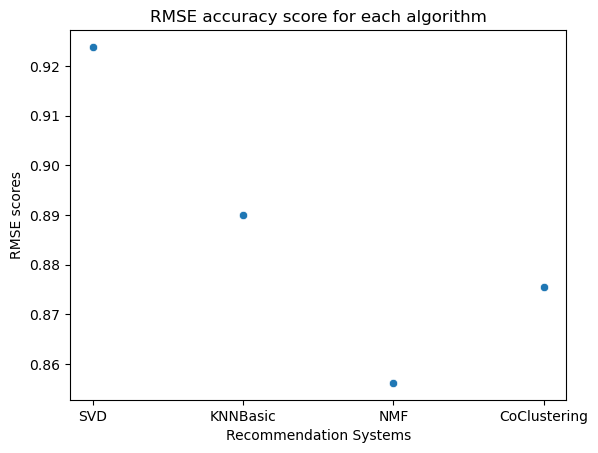

In [38]:
rmse_results = {"Recommendation Systems":["SVD", "KNNBasic", "NMF", "CoClustering"],

        "RMSE scores":[0.9238543405616347,0.8900002593165209,0.8562184119520636,0.8755667411611463]
        };
rmse_data = pd.DataFrame.from_dict(rmse_results)
sns.scatterplot(data = rmse_data, x = "Recommendation Systems", y = "RMSE scores").set(title = "RMSE accuracy score for each algorithm")
plot.show()


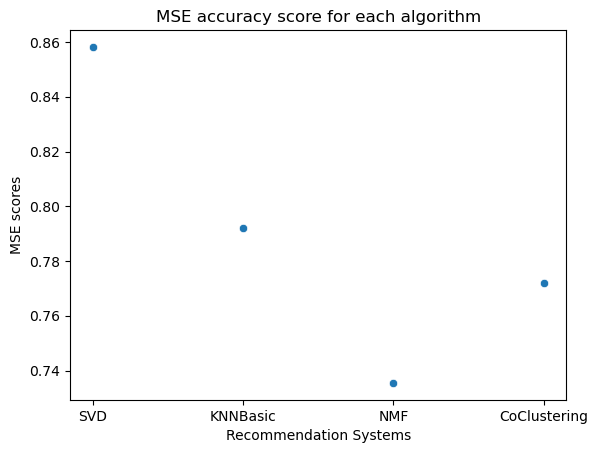

In [39]:
mse_results = {"Recommendation Systems":["SVD", "KNNBasic", "NMF", "CoClustering"],

        "MSE scores":[0.8581979228991218,0.7921004615834746,0.7354765057412563,0.7720403990772148]};
mse_data = pd.DataFrame.from_dict(mse_results)
sns.scatterplot(data = mse_data, x = "Recommendation Systems", y = "MSE scores").set(title = "MSE accuracy score for each algorithm")
plot.show()


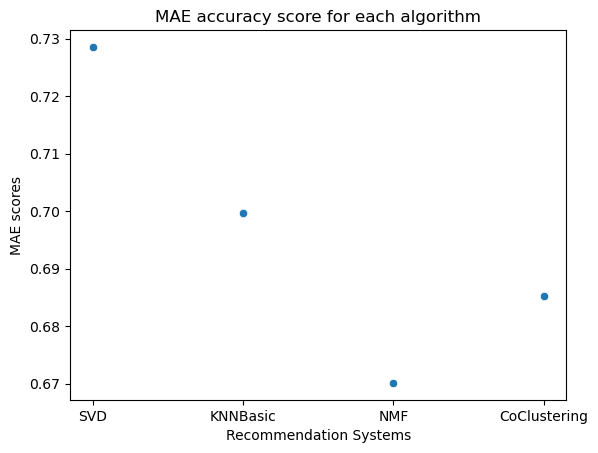

In [40]:
mae_results = {"Recommendation Systems":["SVD", "KNNBasic", "NMF", "CoClustering"],

        "MAE scores":[0.7285452765330812,0.6996161438653726,0.6701458458421166,0.6852191849912497]
        };
mae_data = pd.DataFrame.from_dict(mae_results)
sns.scatterplot(data = mae_data, x = "Recommendation Systems", y = "MAE scores").set(title = "MAE accuracy score for each algorithm")
plot.show()
